In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import plotly.express as px



### Lecture des données

In [3]:
path_to_data = r"C:\Users\meghn\Documents\Dauphine\Master\M2 Finance Quantitative\Semestre 2\Machine Learning\data\\"
train_home_team_statistics_df = pd.read_csv(path_to_data+'Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv(path_to_data+'Train_Data/train_home_team_statistics_df.csv', index_col=0)
train_scores = pd.read_csv(path_to_data+'Y_train_1rknArQ.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]
train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [4]:
train_df = train_data.reset_index().merge(train_scores.reset_index(), on="ID").set_index('ID')

In [5]:
train_df

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std,HOME_WINS,DRAW,AWAY_WINS
ID,,,,,,,,,,,,,,,,,,,,,
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,0.0,10.0,8.0,7.0,2.0,4.0,3.0,0,0,1
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,3.0,10.0,0.0,1.0,2.0,8.0,4.0,0,1,0
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,3.0,6.0,7.0,2.0,3.0,2.0,4.0,0,0,1
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,8.0,8.0,5.0,5.0,5.0,NaN,6.0,1,0,0
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,5.0,8.0,7.0,2.0,6.0,4.0,4.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,4.0,2.0,3.0,4.0,7.0,4.0,4.0,3.0,2.0,2.0,...,5.0,0.0,5.0,0.0,0.0,NaN,4.0,0,0,1
12299,4.0,2.0,3.0,1.0,5.0,1.0,1.0,9.0,1.0,10.0,...,2.0,0.0,0.0,3.0,10.0,6.0,1.0,0,0,1
12300,4.0,3.0,5.0,3.0,5.0,1.0,1.0,6.0,1.0,8.0,...,7.0,0.0,0.0,3.0,1.0,3.0,2.0,0,0,1


On veut voir la répartition des données manquantes, et retirer les données qui ont plus de 100 valeurs manquantes.

<Axes: >

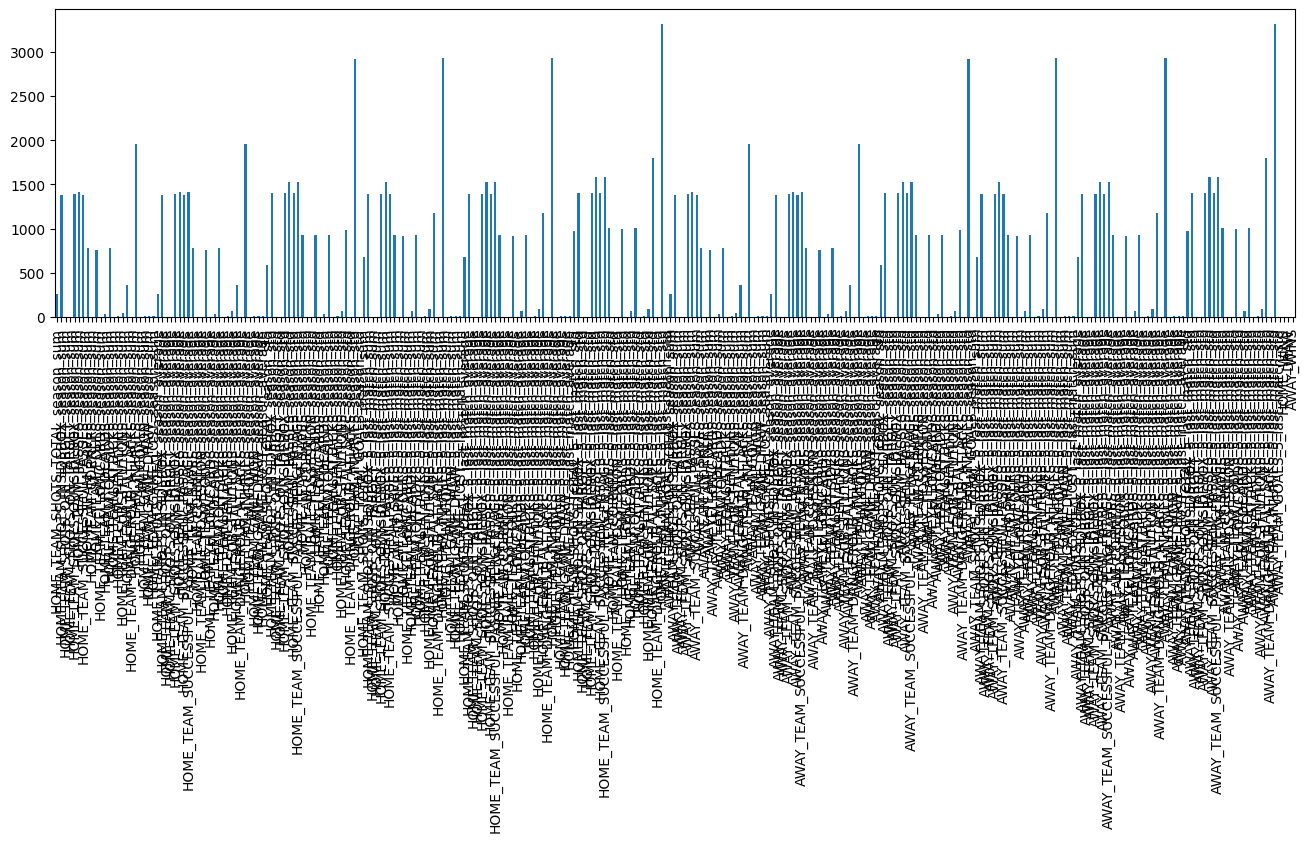

In [6]:
plt.figure(figsize=(16,4))
(len(train_df.index)-train_df.count()).plot.bar()

On retire désormais les colonnes qui ont plus de 100 valeurs manquantes, ainsi que les lignes qui ont des données manquantes.

In [7]:
nan_columns_indices = np.where(train_df.isna().sum() > 100)[0]
nan_columns = train_df.columns[nan_columns_indices]
train_df = train_df.drop(columns=nan_columns)
train_df = train_df.dropna()

In [7]:
train_df.head()

,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_YELLOWCARDS_season_sum,HOME_TEAM_REDCARDS_season_sum,HOME_TEAM_ATTACKS_season_sum,HOME_TEAM_PENALTIES_season_sum,HOME_TEAM_SUBSTITUTIONS_season_sum,HOME_TEAM_DANGEROUS_ATTACKS_season_sum,HOME_TEAM_GOALS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std,HOME_WINS,DRAW,AWAY_WINS
ID,,,,,,,,,,,,,,,,,,,,,
0,5.0,2.0,3.0,2.0,2.0,2.0,6.0,8.0,4.0,3.0,...,3.0,0.0,0.0,10.0,8.0,2.0,3.0,0,0,1
1,3.0,6.0,6.0,3.0,0.0,7.0,6.0,10.0,6.0,10.0,...,4.0,0.0,3.0,10.0,0.0,2.0,4.0,0,1,0
2,5.0,2.0,2.0,7.0,6.0,4.0,5.0,10.0,3.0,1.0,...,4.0,5.0,3.0,6.0,7.0,3.0,4.0,0,0,1
3,5.0,6.0,2.0,0.0,6.0,6.0,5.0,3.0,3.0,5.0,...,4.0,0.0,8.0,8.0,5.0,5.0,6.0,1,0,0
4,2.0,3.0,4.0,4.0,6.0,4.0,3.0,3.0,4.0,3.0,...,1.0,0.0,5.0,8.0,7.0,6.0,4.0,0,1,0


In [8]:
corr_matrix = train_df.corr().select_dtypes(include=[float, int])

In [9]:
corr_matrix

,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_YELLOWCARDS_season_sum,HOME_TEAM_REDCARDS_season_sum,HOME_TEAM_ATTACKS_season_sum,HOME_TEAM_PENALTIES_season_sum,HOME_TEAM_SUBSTITUTIONS_season_sum,HOME_TEAM_DANGEROUS_ATTACKS_season_sum,HOME_TEAM_GOALS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std,HOME_WINS,DRAW,AWAY_WINS
HOME_TEAM_SHOTS_OFF_TARGET_season_sum,1.000000,0.533763,0.511180,-0.084936,-0.064240,0.441538,0.130895,0.045073,0.552578,0.353956,...,-0.040360,-0.036574,0.056052,0.050842,0.009260,0.131437,0.104921,0.131901,-0.036108,-0.107560
HOME_TEAM_SHOTS_ON_TARGET_season_sum,0.533763,1.000000,0.582759,-0.179318,-0.106443,0.499288,0.249561,-0.023196,0.585736,0.714278,...,-0.055713,-0.055255,0.088907,0.129783,0.021898,0.141723,0.270037,0.173633,-0.051178,-0.138124
HOME_TEAM_CORNERS_season_sum,0.511180,0.582759,1.000000,-0.090844,-0.075263,0.462546,0.158774,0.022890,0.654783,0.457803,...,-0.020274,-0.028577,0.084190,0.078657,0.016472,0.168282,0.170592,0.158412,-0.039374,-0.132974
HOME_TEAM_YELLOWCARDS_season_sum,-0.084936,-0.179318,-0.090844,1.000000,0.225176,-0.124025,-0.028679,0.056426,-0.142609,-0.183346,...,0.207459,0.140921,-0.044602,-0.023138,0.007217,-0.060789,-0.088613,-0.057121,0.018728,0.043640
HOME_TEAM_REDCARDS_season_sum,-0.064240,-0.106443,-0.075263,0.225176,1.000000,-0.096453,0.006181,-0.032349,-0.093027,-0.110993,...,0.066428,0.503011,-0.008849,0.012288,0.031679,-0.060237,-0.032970,-0.019113,0.004578,0.016208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,0.131437,0.141723,0.168282,-0.060789,-0.060237,0.155957,0.027946,-0.013384,0.227775,0.110566,...,-0.005019,0.000748,0.361910,0.032871,-0.001861,1.000000,0.041524,0.043051,-0.006099,-0.040513
AWAY_TEAM_GOALS_5_last_match_std,0.104921,0.270037,0.170592,-0.088613,-0.032970,0.154322,0.111049,-0.026201,0.155597,0.330663,...,-0.018743,-0.047563,0.044713,0.119051,0.011812,0.041524,1.000000,0.078890,-0.027938,-0.058302
HOME_WINS,0.131901,0.173633,0.158412,-0.057121,-0.019113,0.135381,0.070622,-0.017328,0.158231,0.175835,...,-0.016376,-0.017554,0.026691,0.038850,0.007523,0.043051,0.078890,1.000000,-0.518845,-0.582397
DRAW,-0.036108,-0.051178,-0.039374,0.018728,0.004578,-0.030661,-0.019294,0.022284,-0.037164,-0.051393,...,0.017638,0.022110,-0.006488,-0.009387,-0.011186,-0.006099,-0.027938,-0.518845,1.000000,-0.392752


In [10]:
corr_matrix.to_excel("correlation_matrix.xlsx")

In [11]:
target_correlations = corr_matrix[['HOME_WINS', 'DRAW', 'AWAY_WINS']].copy()

#### Méthode du benchmark

In [12]:
train_new_y = train_scores['AWAY_WINS']
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)
target = train_scores.loc[X_test.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)


[0]	train-mlogloss:0.68513	eval-mlogloss:0.68892


C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[1]	train-mlogloss:0.67719	eval-mlogloss:0.68483
[2]	train-mlogloss:0.66953	eval-mlogloss:0.68104
[3]	train-mlogloss:0.66238	eval-mlogloss:0.67722
[4]	train-mlogloss:0.65488	eval-mlogloss:0.67373
[5]	train-mlogloss:0.64817	eval-mlogloss:0.67003
[6]	train-mlogloss:0.64126	eval-mlogloss:0.66674
[7]	train-mlogloss:0.63437	eval-mlogloss:0.66369
[8]	train-mlogloss:0.62811	eval-mlogloss:0.66081
[9]	train-mlogloss:0.62169	eval-mlogloss:0.65804
[10]	train-mlogloss:0.61575	eval-mlogloss:0.65558
[11]	train-mlogloss:0.60954	eval-mlogloss:0.65275
[12]	train-mlogloss:0.60364	eval-mlogloss:0.65025
[13]	train-mlogloss:0.59801	eval-mlogloss:0.64800
[14]	train-mlogloss:0.59252	eval-mlogloss:0.64566
[15]	train-mlogloss:0.58750	eval-mlogloss:0.64356
[16]	train-mlogloss:0.58194	eval-mlogloss:0.64121
[17]	train-mlogloss:0.57636	eval-mlogloss:0.63910
[18]	train-mlogloss:0.57130	eval-mlogloss:0.63691
[19]	train-mlogloss:0.56660	eval-mlogloss:0.63482
[20]	train-mlogloss:0.56200	eval-mlogloss:0.63279
[21]	trai

0.4401

#### Méthodes proposées

Noous avons pensé implémenter un modèle en deux étapes, une pipeline. Nous allons d'abord prédire si c'est un match nul, puis si c'est une victoire. 

### 1. Modèle non supervisé

On combine les 3 colonnes de résultat en 1 colonne.

In [8]:
conditions = [
    train_df['HOME_WINS'] == 1,
    train_df['AWAY_WINS'] == 1,
    train_df['DRAW'] == 1
]

values = [1, -1, 0]
train_df['RESULT'] = np.select(conditions, values)

print(train_df[['HOME_WINS', 'DRAW', 'AWAY_WINS', 'RESULT']].head())


    HOME_WINS  DRAW  AWAY_WINS  RESULT
ID                                    
0           0     0          1      -1
1           0     1          0       0
2           0     0          1      -1
3           1     0          0       1
4           0     1          0       0


In [9]:
X = train_df.drop(['HOME_WINS', 'DRAW', 'AWAY_WINS'], axis=1)  
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)

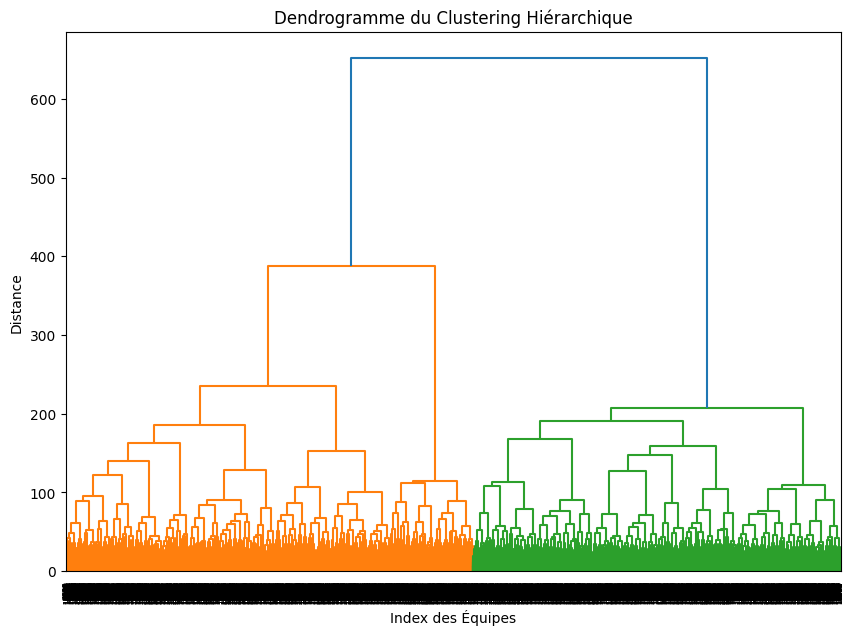

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(data_scaled, method='ward')  
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           labels=X.index,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogramme du Clustering Hiérarchique')
plt.xlabel('Index des Équipes')
plt.ylabel('Distance')
plt.show()

Nous allons désormais trouver le seuil de coupe optimal.

In [15]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score

for threshold in [100, 200, 300, 400, 500]: 
    labels = fcluster(linked, t=threshold, criterion='distance')
    silhouette_avg = silhouette_score(data_scaled, labels)
    print(f"Pour une hauteur de coupe de {threshold}, l'indice de silhouette est : {silhouette_avg}")

Pour une hauteur de coupe de 100, l'indice de silhouette est : -0.004402839971759498
Pour une hauteur de coupe de 200, l'indice de silhouette est : 0.012254229522538334
Pour une hauteur de coupe de 300, l'indice de silhouette est : 0.06712487969118688
Pour une hauteur de coupe de 400, l'indice de silhouette est : 0.09797995557621347
Pour une hauteur de coupe de 500, l'indice de silhouette est : 0.09797995557621347


In [16]:
clusters = fcluster(linked, t=400, criterion='distance')
train_df['Cluster_Label'] = clusters

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X = train_df.drop(['HOME_WINS', 'DRAW', 'AWAY_WINS', 'RESULT'], axis=1)  
y = train_df['RESULT']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.45327295183202965
Classification Report:
               precision    recall  f1-score   support

          -1       0.40      0.38      0.39       747
           0       0.32      0.02      0.04       645
           1       0.48      0.78      0.59      1037

    accuracy                           0.45      2429
   macro avg       0.40      0.39      0.34      2429
weighted avg       0.41      0.45      0.38      2429



C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
cluster_stats = pd.DataFrame(train_df.groupby('Cluster_Label').agg(['mean', 'std']))
print(cluster_stats.head())


              HOME_TEAM_SHOTS_OFF_TARGET_season_sum            \
                                               mean       std   
Cluster_Label                                                   
1                                          3.250434  2.301582   
2                                          5.644525  2.716306   

              HOME_TEAM_SHOTS_ON_TARGET_season_sum            \
                                              mean       std   
Cluster_Label                                                  
1                                         2.423638  1.944326   
2                                         5.704214  2.634224   

              HOME_TEAM_CORNERS_season_sum            \
                                      mean       std   
Cluster_Label                                          
1                                 3.060916  2.207655   
2                                 5.796961  2.618213   

              HOME_TEAM_YELLOWCARDS_season_sum            \
            

In [21]:
mean_diff_threshold = 0.1 * train_df.mean()
diff_means = abs(cluster_stats.loc[1, (slice(None), 'mean')] - cluster_stats.loc[2, (slice(None), 'mean')])
significant_features = [col[0] for col in diff_means.index if diff_means[col] > mean_diff_threshold[col[0]]]

print("Features significatives à conserver :", significant_features)


Features significatives à conserver : ['HOME_TEAM_SHOTS_OFF_TARGET_season_sum', 'HOME_TEAM_SHOTS_ON_TARGET_season_sum', 'HOME_TEAM_CORNERS_season_sum', 'HOME_TEAM_YELLOWCARDS_season_sum', 'HOME_TEAM_REDCARDS_season_sum', 'HOME_TEAM_ATTACKS_season_sum', 'HOME_TEAM_PENALTIES_season_sum', 'HOME_TEAM_DANGEROUS_ATTACKS_season_sum', 'HOME_TEAM_GOALS_season_sum', 'HOME_TEAM_GAME_WON_season_sum', 'HOME_TEAM_GAME_LOST_season_sum', 'HOME_TEAM_SHOTS_OFF_TARGET_season_average', 'HOME_TEAM_SHOTS_ON_TARGET_season_average', 'HOME_TEAM_CORNERS_season_average', 'HOME_TEAM_BALL_POSSESSION_season_average', 'HOME_TEAM_YELLOWCARDS_season_average', 'HOME_TEAM_REDCARDS_season_average', 'HOME_TEAM_ATTACKS_season_average', 'HOME_TEAM_PENALTIES_season_average', 'HOME_TEAM_DANGEROUS_ATTACKS_season_average', 'HOME_TEAM_GOALS_season_average', 'HOME_TEAM_GAME_WON_season_average', 'HOME_TEAM_GAME_LOST_season_average', 'HOME_TEAM_SHOTS_OFF_TARGET_season_std', 'HOME_TEAM_SHOTS_ON_TARGET_season_std', 'HOME_TEAM_CORNERS

In [24]:
X_filtered = train_df[significant_features].drop(['HOME_WINS', 'AWAY_WINS', 'RESULT'], axis=1)  
y = train_df['RESULT']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.45409633594071636
Classification Report:
               precision    recall  f1-score   support

          -1       0.39      0.36      0.37       747
           0       0.25      0.01      0.02       645
           1       0.48      0.80      0.60      1037

    accuracy                           0.45      2429
   macro avg       0.37      0.39      0.33      2429
weighted avg       0.39      0.45      0.38      2429



C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Nous pouvons constater qu'il n'y a pas une énorme différence entre le modèle avec les colonnes filtrées en fonction du cluster. Ainsi, nous allons continuer avec notre modèle 1 pour l'optimisation des hyper paramètres.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')  

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2']        
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur score : ", grid_search.best_score_)

best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
print("Accuracy sur l'ensemble de test :", accuracy_score(y_test, predictions))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres :  {'C': 0.1, 'penalty': 'l1'}
Meilleur score :  0.4600647782797379
Accuracy sur l'ensemble de test : 0.45903664059283655


Ce modèle a donc une performance supérieure à celle du benchmark (accuracy), mais ceci nous donne une différence marginale.

### 2. Modèle supervisé : Random Forest Classfier

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# pour le grid search CV
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30],        
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]     
}

In [22]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# errors outputs the MSE of the Gradient Boosting for each tree's iteration t=1,...,120
errors = [mean_squared_error(y_test, y_pred)
          for y_pred in gbrt.staged_predict(X_test)]

In [28]:
min_error = np.min(errors)
bst_n_estimators = np.argmin(errors) + 1


In [29]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=43, random_state=42)

In [23]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score de validation croisée :", grid_search.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs paramètres trouvés : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score de validation croisée : 0.4539922778614378


In [24]:
best_rf_model = grid_search.best_estimator_
test_predictions = best_rf_model.predict(X_test)
print("Accuracy sur l'ensemble de test :", accuracy_score(y_test, test_predictions))
print("Rapport de classification :\n", classification_report(y_test, test_predictions))


Accuracy sur l'ensemble de test : 0.4520378756689996
Rapport de classification :
               precision    recall  f1-score   support

          -1       0.40      0.37      0.38       747
           0       0.56      0.01      0.02       645
           1       0.47      0.79      0.59      1037

    accuracy                           0.45      2429
   macro avg       0.48      0.39      0.33      2429
weighted avg       0.47      0.45      0.37      2429



In [26]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class DrawWinLossClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier_draw, classifier_win_loss):
        self.classifier_draw = classifier_draw
        self.classifier_win_loss = classifier_win_loss

    def fit(self, X, y):
        y_draw = (y == 0).astype(int)
        self.classifier_draw.fit(X, y_draw)

        non_draw_indices = (y != 0)
        X_non_draw = X[non_draw_indices]
        y_win_loss = y[non_draw_indices]

        if X_non_draw.shape[0] > 0:
            self.classifier_win_loss.fit(X_non_draw, y_win_loss)
        
        return self
    
    def predict(self, X):
        draw_predictions = self.classifier_draw.predict(X)
        final_predictions = np.full(X.shape[0], -99)  # Initialize with a default value that's clearly wrong

        # Predict non-draws
        non_draw_indices = draw_predictions == 0
        if np.any(non_draw_indices):
            win_loss_predictions = self.classifier_win_loss.predict(X[non_draw_indices])
            final_predictions[non_draw_indices] = win_loss_predictions

        # Assign draw predictions
        final_predictions[draw_predictions == 1] = 0  # Assuming '0' is the code for 'draw'

        return final_predictions


In [28]:
custom_classifier = DrawWinLossClassifier(
    classifier_draw=RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, class_weight='balanced'),
    classifier_win_loss=RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
)

custom_classifier.fit(X_train, y_train)

predictions = custom_classifier.predict(X_test)

# Evaluate the results
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))


Accuracy: 0.45244956772334294
Classification Report:
               precision    recall  f1-score   support

          -1       0.40      0.39      0.40       747
           0       0.40      0.00      0.01       645
           1       0.48      0.78      0.59      1037

    accuracy                           0.45      2429
   macro avg       0.42      0.39      0.33      2429
weighted avg       0.43      0.45      0.38      2429



In [33]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Define base learners
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
]

stack_model = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    stack_method='predict_proba',
    passthrough=True
)

# Fit the model on the training data
stack_model.fit(X_train, y_train)

# Evaluate the model
stack_predictions = stack_model.predict(X_test)
print("Stacking Model Accuracy:", accuracy_score(y_test, stack_predictions))
print("Classification Report:\n", classification_report(y_test, stack_predictions))


C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Model Accuracy: 0.44833264717990945
Classification Report:
               precision    recall  f1-score   support

          -1       0.38      0.37      0.38       747
           0       0.28      0.02      0.03       645
           1       0.48      0.77      0.59      1037

    accuracy                           0.45      2429
   macro avg       0.38      0.39      0.33      2429
weighted avg       0.40      0.45      0.38      2429



In [70]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialisation du modèle Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entraînement du modèle
gb_model.fit(X_train, y_train)

# Évaluation du modèle
gb_predictions = gb_model.predict(X_test)
print("Accuracy sur l'ensemble de test :", accuracy_score(y_test, gb_predictions))
print("Rapport de classification :\n", classification_report(y_test, gb_predictions))


Accuracy sur l'ensemble de test : 0.4450391107451626
Rapport de classification :
               precision    recall  f1-score   support

          -1       0.37      0.35      0.36       747
           0       0.29      0.03      0.05       645
           1       0.48      0.77      0.59      1037

    accuracy                           0.45      2429
   macro avg       0.38      0.38      0.33      2429
weighted avg       0.40      0.45      0.38      2429



MOdele 3


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Adding L2 regularization
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.1),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
y_train_encoded = y_train + 1  # This shifts -1, 0, 1 to 0, 1, 2 for use with sparse_categorical_crossentropy

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32,
                    validation_split=0.1, callbacks=[early_stopping])


C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4122 - loss: 2.3493 - val_accuracy: 0.4475 - val_loss: 1.5608
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4486 - loss: 1.4349 - val_accuracy: 0.4578 - val_loss: 1.1929
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4568 - loss: 1.1547 - val_accuracy: 0.4578 - val_loss: 1.0971
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4542 - loss: 1.0812 - val_accuracy: 0.4424 - val_loss: 1.0709
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4596 - loss: 1.0569 - val_accuracy: 0.4434 - val_loss: 1.0626
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4748 - loss: 1.0460 - val_accuracy: 0.4414 - val_loss: 1.0625
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4593 - loss: 1.0524 - val_accuracy: 0.4403 - val_loss: 1.0624
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4531 - loss: 1.0559 - val_accuracy: 0.

In [30]:
# Convert y_train to categorical if it's not already
y_train_encoded = y_train + 1  # This shifts -1, 0, 1 to 0, 1, 2 for use with sparse_categorical_crossentropy

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)


Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4543 - loss: 1.0589 - val_accuracy: 0.4393 - val_loss: 1.0580
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4607 - loss: 1.0511 - val_accuracy: 0.4414 - val_loss: 1.0631
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4636 - loss: 1.0471 - val_accuracy: 0.4568 - val_loss: 1.0586
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4550 - loss: 1.0500 - val_accuracy: 0.4486 - val_loss: 1.0586
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4613 - loss: 1.0453 - val_accuracy: 0.4342 - val_loss: 1.0580
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4695 - loss: 1.0478 - val_accuracy: 0.4486 - val_loss: 1.0592
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4634 - loss: 1.0475 - val_accuracy: 0.4414 - val_loss: 1.0612
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4571 - loss: 1.0512 - val_accuracy: 0.

In [31]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1) - 1
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predicted_classes))
print(confusion_matrix(y_test, predicted_classes))


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

          -1       0.39      0.47      0.43       747
           0       0.00      0.00      0.00       645
           1       0.50      0.73      0.59      1037

    accuracy                           0.46      2429
   macro avg       0.30      0.40      0.34      2429
weighted avg       0.33      0.46      0.38      2429

[[352   0 395]
 [272   0 373]
 [276   0 761]]


C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

In [86]:
from sklearn.model_selection import train_test_split
X = train_df.drop(['HOME_WINS', 'DRAW', 'AWAY_WINS', "RESULT"], axis=1)
y_draw = train_df['DRAW'] 
y_win_loss = train_df['HOME_WINS'][train_df['DRAW'] == 0]

X_train, X_test, y_draw_train, y_draw_test = train_test_split(X, y_draw, test_size=0.2, random_state=42)
X_train_non_draw = X_train[y_draw_train == 0]
y_win_loss_train = y_win_loss.loc[y_win_loss.index.intersection(X_train_non_draw.index)]

In [ ]:
X_train

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
pipeline_draw = Pipeline([
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Pipeline for predicting win/loss
pipeline_win_loss = Pipeline([
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [88]:
# Grid search parameters
param_grid_draw = {
    'feature_selection__k': [10, 20, 30],  
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, 30]
}

param_grid_win_loss = {
    'feature_selection__k': [10, 20, 30],  
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, 30]
}

# Grid search objects
grid_search_draw = GridSearchCV(pipeline_draw, param_grid_draw, cv=5, scoring='accuracy')
grid_search_win_loss = GridSearchCV(pipeline_win_loss, param_grid_win_loss, cv=5, scoring='accuracy')


In [ ]:
# Grid search objects
grid_search_draw = GridSearchCV(pipeline_draw, param_grid_draw, cv=5, scoring='accuracy')
grid_search_win_loss = GridSearchCV(pipeline_win_loss, param_grid_win_loss, cv=5, scoring='accuracy')
grid_search_draw.fit(X_train, y_draw_train)
print("Best parameters for draw model:", grid_search_draw.best_params_)
print("Best score for draw model:", grid_search_draw.best_score_)

if X_train_non_draw.shape[0] > 0:
    grid_search_win_loss.fit(X_train_non_draw, y_win_loss_train)
    print("Best parameters for win/loss model:", grid_search_win_loss.best_params_)
    print("Best score for win/loss model:", grid_search_win_loss.best_score_)

In [18]:
y_draw_pred = grid_search_draw.predict(X_test)

X_test_non_draw = X_test[y_draw_pred == 0]
y_win_loss_test = y_win_loss.loc[y_win_loss.index.intersection(X_test_non_draw.index)]

y_win_loss_pred = grid_search_win_loss.predict(X_test_non_draw) if X_test_non_draw.shape[0] > 0 else []

from sklearn.metrics import accuracy_score, classification_report

draw_accuracy = accuracy_score(y_draw_test, y_draw_pred)
print("Accuracy for draw prediction:", draw_accuracy)
print("Classification Report for Draw Prediction:\n", classification_report(y_draw_test, y_draw_pred))


Accuracy for draw prediction: 0.7344586249485385
Classification Report for Draw Prediction:
               precision    recall  f1-score   support

           0       0.73      1.00      0.85      1784
           1       0.00      0.00      0.00       645

    accuracy                           0.73      2429
   macro avg       0.37      0.50      0.42      2429
weighted avg       0.54      0.73      0.62      2429



C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meghn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471

In [19]:
X_test_non_draw = X_test[y_draw_test == 0]
y_win_loss_test = y_win_loss.loc[X_test_non_draw.index]  

if X_test_non_draw.shape[0] > 0:
    y_win_loss_pred = grid_search_win_loss.predict(X_test_non_draw)
    win_loss_accuracy = accuracy_score(y_win_loss_test, y_win_loss_pred)
    print("Accuracy for win/loss prediction:", win_loss_accuracy)
    print("Classification Report for Win/Loss Prediction:\n", classification_report(y_win_loss_test, y_win_loss_pred))
else:
    print("No non-draw matches in the test set to predict.")


Accuracy for win/loss prediction: 0.5639013452914798
Classification Report for Win/Loss Prediction:
               precision    recall  f1-score   support

           0       0.37      0.06      0.11       747
           1       0.58      0.93      0.71      1037

    accuracy                           0.56      1784
   macro avg       0.48      0.49      0.41      1784
weighted avg       0.49      0.56      0.46      1784



In [20]:
y_test = np.where(train_df['DRAW'][X_test.index] == 1, 'DRAW',
                  np.where(train_df['HOME_WINS'][X_test.index] == 1, 'HOME_WINS', 'AWAY_WINS'))



In [21]:
combined_predictions = np.full_like(y_test, 'PENDING', dtype=object)
combined_predictions[y_draw_pred == 1] = 'DRAW'
non_draw_indices = np.where(y_draw_pred == 0)[0] 


In [22]:
if y_win_loss_pred.size > 0:
    # We need to ensure that non_draw_indices used here matches the length of y_win_loss_pred
    # Adjust the non_draw_indices to match the exact count of y_win_loss_pred if not aligned
    if non_draw_indices.size != y_win_loss_pred.size:
        # Only consider as many indices as there are predictions
        non_draw_indices = non_draw_indices[:y_win_loss_pred.size]

    combined_predictions[non_draw_indices] = np.where(y_win_loss_pred == 1, 'HOME_WINS', 'AWAY_WINS')


global_accuracy = accuracy_score(y_test, combined_predictions)
print("Global Accuracy of the model:", global_accuracy)

Global Accuracy of the model: 0.3095924248662001


In [23]:
import numpy as np
y_test = np.where(train_df['DRAW'][X_test.index] == 1, 'DRAW',
                  np.where(train_df['HOME_WINS'][X_test.index] == 1, 'HOME_WINS', 'AWAY_WINS'))

combined_predictions = np.full_like(y_test, 'PENDING', dtype=object)

combined_predictions[y_draw_pred == 1] = 'DRAW'

non_draw_indices = np.where(y_draw_pred == 0)[0]  

# Update non-draw predictions
if y_win_loss_pred.size > 0:
    combined_predictions[non_draw_indices] = np.where(y_win_loss_pred == 1, 'HOME_WINS', 'AWAY_WINS')

# Calculate global accuracy
global_accuracy = accuracy_score(y_test, combined_predictions)
print("Global Accuracy of the model:", global_accuracy)


ValueError: shape mismatch: value array of shape (1784,) could not be broadcast to indexing result of shape (2429,)

In [29]:
print("Number of draws predicted:", np.sum(y_draw_pred == 1))
print("Number of non-draws predicted:", np.sum(y_draw_pred == 0))
print("Predictions for non-draws available:", y_win_loss_pred.size)

# Checking a random sample of combined predictions
sample_indices = np.random.choice(len(combined_predictions), 10, replace=False)
print("Sample of combined predictions and actual outcomes:")
for idx in sample_indices:
    print(f"Predicted: {combined_predictions[idx]}, Actual: {y_test[idx]}")


Number of draws predicted: 6
Number of non-draws predicted: 2423
Predictions for non-draws available: 2423
Sample of combined predictions and actual outcomes:
Predicted: HOME_WINS, Actual: HOME_WINS
Predicted: HOME_WINS, Actual: HOME_WINS
Predicted: HOME_WINS, Actual: DRAW
Predicted: HOME_WINS, Actual: DRAW
Predicted: HOME_WINS, Actual: AWAY_WINS
Predicted: HOME_WINS, Actual: AWAY_WINS
Predicted: HOME_WINS, Actual: AWAY_WINS
Predicted: HOME_WINS, Actual: HOME_WINS
Predicted: HOME_WINS, Actual: HOME_WINS
Predicted: HOME_WINS, Actual: HOME_WINS


In [25]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Resample all classes but the majority class
X_res, y_res = smote.fit_resample(X_train, y_draw_train)

# Check the balance
print(np.bincount(y_res))

[7213 7213]


In [26]:
pipeline_draw = Pipeline([
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_draw = {
    'feature_selection__k': [10, 20, 30],  
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, 30]
}

grid_search_draw = GridSearchCV(pipeline_draw, param_grid_draw, cv=5, scoring='accuracy')

grid_search_draw.fit(X_res, y_res)

print("Best parameters for draw model:", grid_search_draw.best_params_)
print("Best score for draw model:", grid_search_draw.best_score_)

y_draw_pred = grid_search_draw.predict(X_test)
draw_accuracy = accuracy_score(y_draw_test, y_draw_pred)
print("Accuracy for draw prediction on test data:", draw_accuracy)
print("Classification Report for Draw Prediction on test data:\n", classification_report(y_draw_test, y_draw_pred))

Best parameters for draw model: {'classifier__max_depth': 10, 'classifier__n_estimators': 200, 'feature_selection__k': 20}
Best score for draw model: 0.8200693000693
Accuracy for draw prediction on test data: 0.7336352408398518
Classification Report for Draw Prediction on test data:
               precision    recall  f1-score   support

           0       0.73      1.00      0.85      1784
           1       0.33      0.00      0.01       645

    accuracy                           0.73      2429
   macro avg       0.53      0.50      0.43      2429
weighted avg       0.63      0.73      0.62      2429



In [27]:
combined_predictions = np.full_like(y_test, 'PENDING', dtype=object)
combined_predictions[y_draw_pred == 1] = 'DRAW'
non_draw_indices = np.where(y_draw_pred == 0)[0]

# Adjust non_draw_indices to match the length of y_win_loss_pred if necessary
if non_draw_indices.size != y_win_loss_pred.size:
    non_draw_indices = non_draw_indices[:y_win_loss_pred.size]

combined_predictions[non_draw_indices] = np.where(y_win_loss_pred == 1, 'HOME_WINS', 'AWAY_WINS')

# Calculate the updated global accuracy
global_accuracy = accuracy_score(y_test, combined_predictions)
print("Updated Global Accuracy of the model:", global_accuracy)

Updated Global Accuracy of the model: 0.3112391930835735


In [30]:
y_draw_pred = grid_search_draw.predict(X_test)

X_test_non_draw = X_test[y_draw_pred == 0]
y_test_non_draw = y_win_loss.loc[y_win_loss.index.intersection(X_test_non_draw.index)]

if X_test_non_draw.shape[0] > 0:
    y_win_loss_pred = grid_search_win_loss.predict(X_test_non_draw)
else:
    y_win_loss_pred = np.array([])  

combined_predictions = np.full_like(y_test, 'PENDING', dtype=object)
combined_predictions[y_draw_pred == 1] = 'DRAW'
non_draw_indices = np.where(y_draw_pred == 0)[0]

if y_win_loss_pred.size > 0:
    combined_predictions[non_draw_indices[:len(y_win_loss_pred)]] = np.where(y_win_loss_pred == 1, 'HOME_WINS', 'AWAY_WINS')

global_accuracy = accuracy_score(y_test, combined_predictions)
print("Updated Global Accuracy of the model:", global_accuracy)


Updated Global Accuracy of the model: 0.41375051461506795
